In [2]:
import pandas as pd   
import numpy as np                 
import seaborn as sns
import matplotlib.pyplot as plt                      

In [3]:
df=pd.read_excel(r"D:\ALL\ai/Online Retail.xlsx")

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(5268)

In [8]:
# Calculate TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

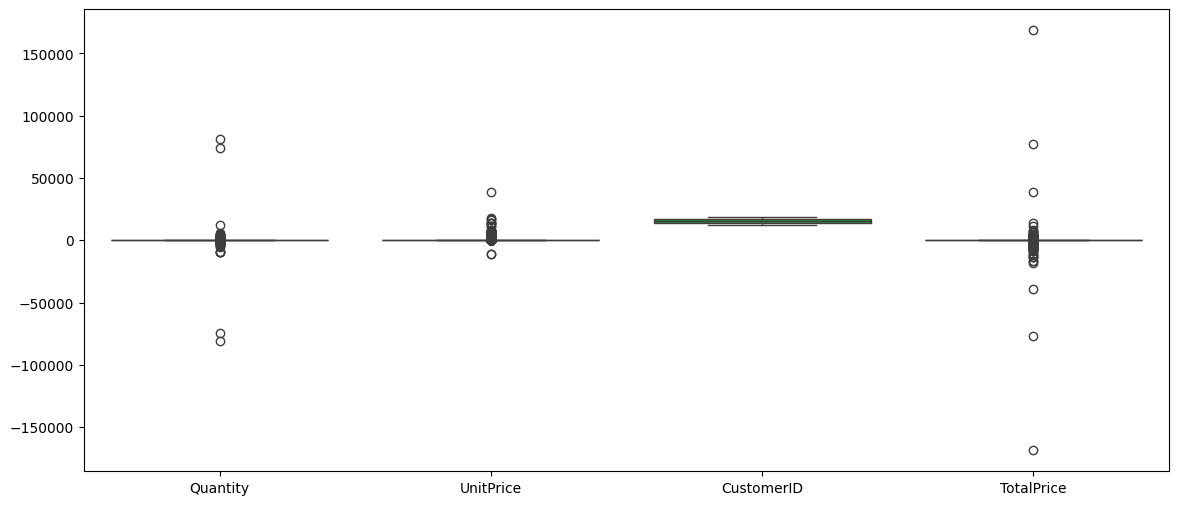

In [9]:
# Visualize outliers before cleaning
plt.figure(figsize=(14,6))
sns.boxplot(data=df)
plt.show()


In [10]:
# Describe numerical features
print(df[['Quantity','UnitPrice','TotalPrice']].describe())

            Quantity      UnitPrice     TotalPrice
count  541909.000000  541909.000000  541909.000000
mean        9.552250       4.611114      17.987795
std       218.081158      96.759853     378.810824
min    -80995.000000  -11062.060000 -168469.600000
25%         1.000000       1.250000       3.400000
50%         3.000000       2.080000       9.750000
75%        10.000000       4.130000      17.400000
max     80995.000000   38970.000000  168469.600000


#  Data Cleaning and Outlier Handling 

In [11]:
# Remove negative or zero quantities and unit prices
df_clean = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)].copy()

In [12]:
# Recalculate TotalPrice
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

In [13]:
print(df_clean[['Quantity','UnitPrice','TotalPrice']].describe())

            Quantity      UnitPrice     TotalPrice
count  530104.000000  530104.000000  530104.000000
mean       10.542037       3.907625      20.121871
std       155.524124      35.915681     270.356743
min         1.000000       0.001000       0.001000
25%         1.000000       1.250000       3.750000
50%         3.000000       2.080000       9.900000
75%        10.000000       4.130000      17.700000
max     80995.000000   13541.330000  168469.600000


In [14]:
# Function to cap outliers using IQR method
def cap_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return np.clip(col, lower, upper)

In [15]:
df_clean['Quantity'] = cap_outliers(df_clean['Quantity'])
df_clean['UnitPrice'] = cap_outliers(df_clean['UnitPrice'])
df_clean['TotalPrice'] = cap_outliers(df_clean['TotalPrice'])

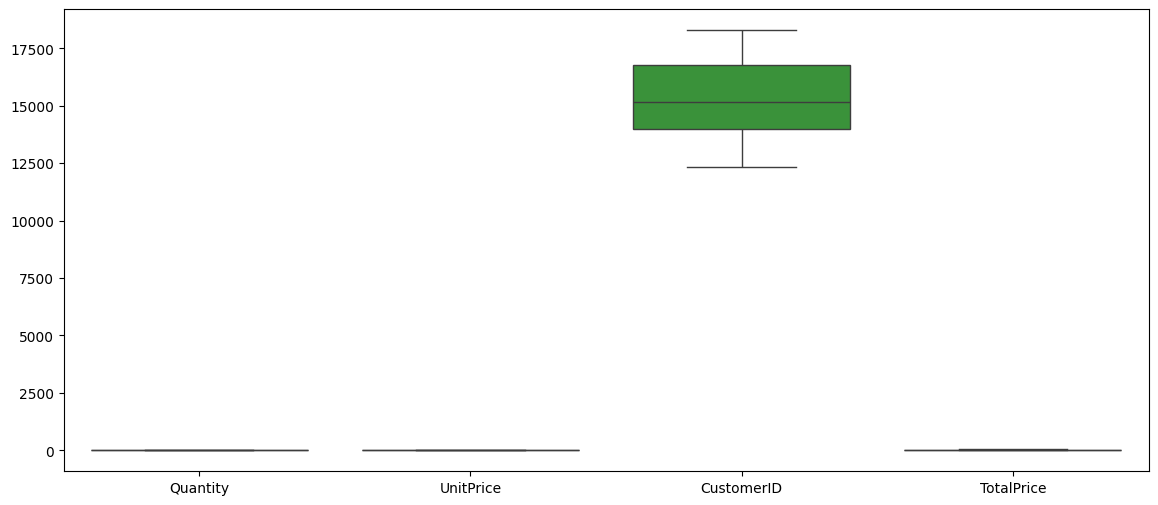

In [16]:
# Visualize cleaned data
plt.figure(figsize=(14,6))
sns.boxplot(data=df_clean)
plt.show()


#  Remove cancelled orders and missing CustomerID 


In [17]:
df_clean= df_clean[~df_clean['InvoiceNo'].astype(str).str.startswith('C')]

df_clean= df_clean[df_clean['Quantity'] > 0]

df_clean = df_clean.dropna(subset=['CustomerID'])

In [18]:
# Fill missing descriptions
df_clean['Description'] = df_clean['Description'].fillna('Unknown')

In [19]:
# Remove duplicates
df_clean = df_clean.drop_duplicates()

In [20]:
# Recalculate TotalPrice after cleaning
df_clean['TotalPrice'] = df_clean['Quantity'] * df_clean['UnitPrice']

#  Feature Engineering 


In [21]:
# Extract temporal features
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Hour'] = df_clean['InvoiceDate'].dt.hour
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.dayofweek
df_clean['Month'] = df_clean['InvoiceDate'].dt.month

In [22]:
# Define season based on month
def get_season(month):
    if month in [12, 1, 2]: 
        return 'Winter'
    elif month in [3, 4, 5]: 
        return 'Spring'
    elif month in [6, 7, 8]: 
        return 'Summer'
    else: 
        return 'Autumn'

df_clean['Season'] = df_clean['Month'].apply(get_season)


In [23]:
max_date = df_clean['InvoiceDate'].max()

rfm = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (max_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                               # Frequency
    'TotalPrice': 'sum'                                   # Monetary
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']


In [24]:
# CLV Calculation
clv = df_clean.groupby('CustomerID')['TotalPrice'].sum().reset_index()
clv.columns = ['CustomerID', 'CLV']

In [25]:
df_cleanr = df_clean.merge(rfm, on='CustomerID', how='left')
df_clean = df_cleanr.merge(clv, on='CustomerID', how='left')

In [26]:
df_clean['Category'] = df_clean['Description'].astype(str).str.split().str[0]

In [27]:
# Encode categorical features
df_clean['CountryCode'] = df_clean['Country'].astype('category').cat.codes
df_clean['SeasonCode'] = df_clean['Season'].astype('category').cat.codes
df_clean['CategoryCode'] = df_clean['Category'].astype('category').cat.codes

In [28]:
#numerical 
from sklearn.preprocessing import StandardScaler
num_features = ['Quantity','UnitPrice','TotalPrice','Hour','DayOfWeek','Month','Recency', 'Frequency', 'Monetary', 'CLV']
scaler = StandardScaler()
df_clean[num_features] = scaler.fit_transform(df_clean[num_features])


In [29]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392670 entries, 0 to 392669
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     392670 non-null  object        
 1   StockCode     392670 non-null  object        
 2   Description   392670 non-null  object        
 3   Quantity      392670 non-null  float64       
 4   InvoiceDate   392670 non-null  datetime64[ns]
 5   UnitPrice     392670 non-null  float64       
 6   CustomerID    392670 non-null  float64       
 7   Country       392670 non-null  object        
 8   TotalPrice    392670 non-null  float64       
 9   Hour          392670 non-null  float64       
 10  DayOfWeek     392670 non-null  float64       
 11  Month         392670 non-null  float64       
 12  Season        392670 non-null  object        
 13  Recency       392670 non-null  float64       
 14  Frequency     392670 non-null  float64       
 15  Monetary      392

In [30]:
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Hour,...,Month,Season,Recency,Frequency,Monetary,CLV,Category,CountryCode,SeasonCode,CategoryCode
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-0.281520,2010-12-01 08:26:00,-0.053827,17850.0,United Kingdom,0.018515,-2.073867,...,1.287884,Winter,5.059093,0.40794,-0.163512,-0.163512,WHITE,35,3,801
1,536365,71053,WHITE METAL LANTERN,-0.281520,2010-12-01 08:26:00,0.315198,17850.0,United Kingdom,0.314586,-2.073867,...,1.287884,Winter,5.059093,0.40794,-0.163512,-0.163512,WHITE,35,3,801
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,-0.015269,2010-12-01 08:26:00,0.034036,17850.0,United Kingdom,0.412101,-2.073867,...,1.287884,Winter,5.059093,0.40794,-0.163512,-0.163512,CREAM,35,3,201
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,-0.281520,2010-12-01 08:26:00,0.315198,17850.0,United Kingdom,0.314586,-2.073867,...,1.287884,Winter,5.059093,0.40794,-0.163512,-0.163512,KNITTED,35,3,413
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,-0.281520,2010-12-01 08:26:00,0.315198,17850.0,United Kingdom,0.314586,-2.073867,...,1.287884,Winter,5.059093,0.40794,-0.163512,-0.163512,RED,35,3,615


Exploratory Data Analysis

In [31]:
try:
    from caas_jupyter_tools import display_dataframe_to_user
    have_display_helper = True
except Exception:
    have_display_helper = False

In [32]:
country_counts = df['Country'].value_counts().rename_axis('Country').reset_index(name='Transactions')
country_spend = df.groupby('Country')['TotalPrice'].sum().reset_index().sort_values('TotalPrice', ascending=False)

top_countries = country_spend.head(20)
if have_display_helper:
    display_dataframe_to_user("top coutries by total spend", top_countries)
else:
    print("top countries by total spending (top 10):")
    print(top_countries.head(10).to_string(index=False))

top countries by total spending (top 10):
       Country  TotalPrice
United Kingdom 8187806.364
   Netherlands  284661.540
          EIRE  263276.820
       Germany  221698.210
        France  197403.900
     Australia  137077.270
   Switzerland   56385.350
         Spain   54774.580
       Belgium   40910.960
        Sweden   36595.910


 Plot transactions and spending for top countries

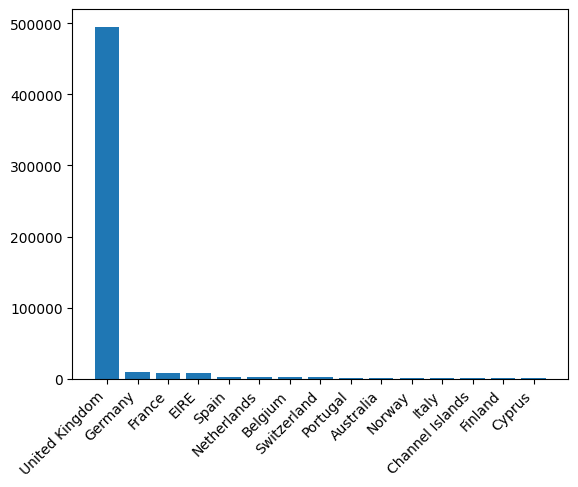

In [33]:
#Countries by Number of Transactions
top_n = 15
top_by_tx = country_counts.head(top_n)

plt.bar(top_by_tx['Country'], top_by_tx['Transactions'])
plt.xticks(rotation=45, ha='right')

plt.show()

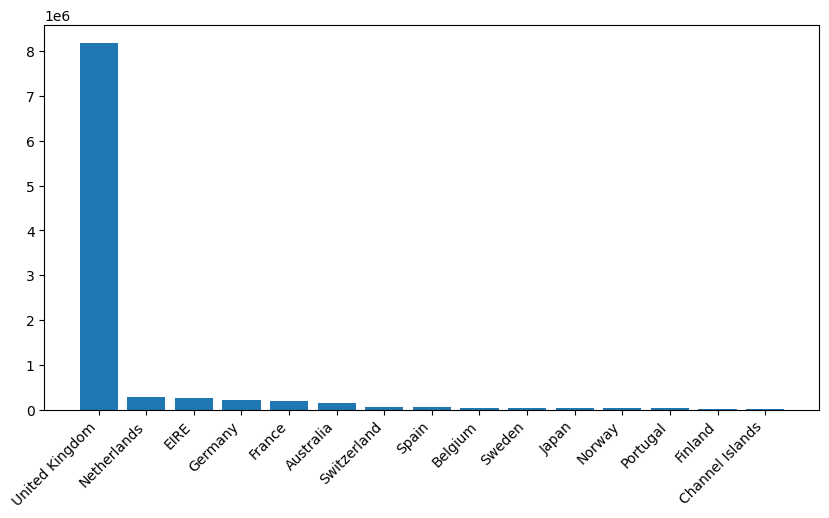

In [34]:
#Countries by Total Spending
plt.figure(figsize=(10,5))
plt.bar(top_countries['Country'].head(top_n), top_countries['TotalPrice'].head(top_n))
plt.xticks(rotation=45, ha='right')

plt.show()

3) Time-series: sales trends (2010-2011)

monthly sales sample:
InvoiceDate  TotalPrice  YearMonth
 2010-12-31  748957.020 2010-12-01
 2011-01-31  560000.260 2011-01-01
 2011-02-28  498062.650 2011-02-01
 2011-03-31  683267.080 2011-03-01
 2011-04-30  493207.121 2011-04-01


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10672\3685140877.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().reset_index()


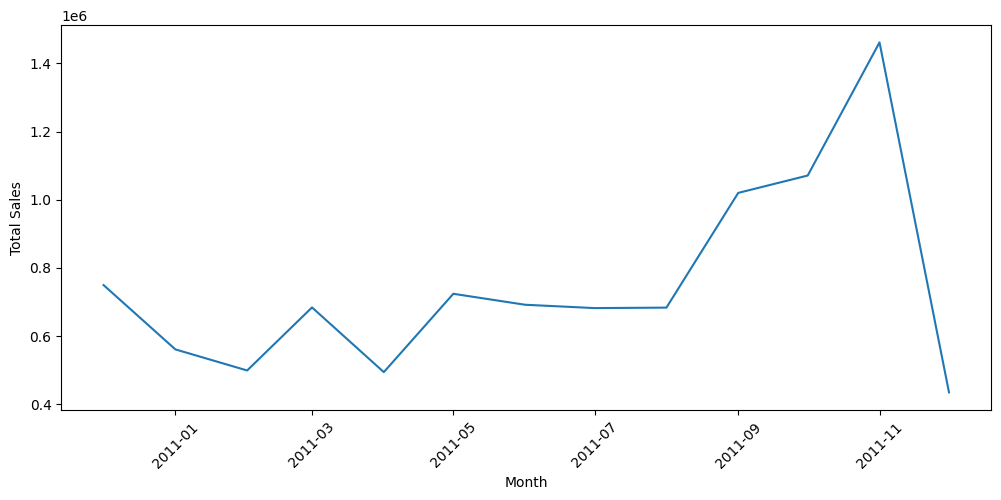

In [35]:
ts = df.set_index('InvoiceDate').resample('M')['TotalPrice'].sum().reset_index()
ts['YearMonth'] = ts['InvoiceDate'].dt.to_period('M').dt.to_timestamp()
if have_display_helper:
    display_dataframe_to_user("monthly sales time series (all)", ts)
else:
    print("monthly sales sample:")
    print(ts.head().to_string(index=False))

plt.figure(figsize=(12,5))

plt.plot(ts['YearMonth'], ts['TotalPrice'])
plt.xlabel("Month")
plt.ylabel("Total Sales")

plt.xticks(rotation=45)
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10672\1690826958.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  uk_ts = df[df['Country']=='United Kingdom'].set_index('InvoiceDate').resample('M')['TotalPrice'].sum().reset_index()


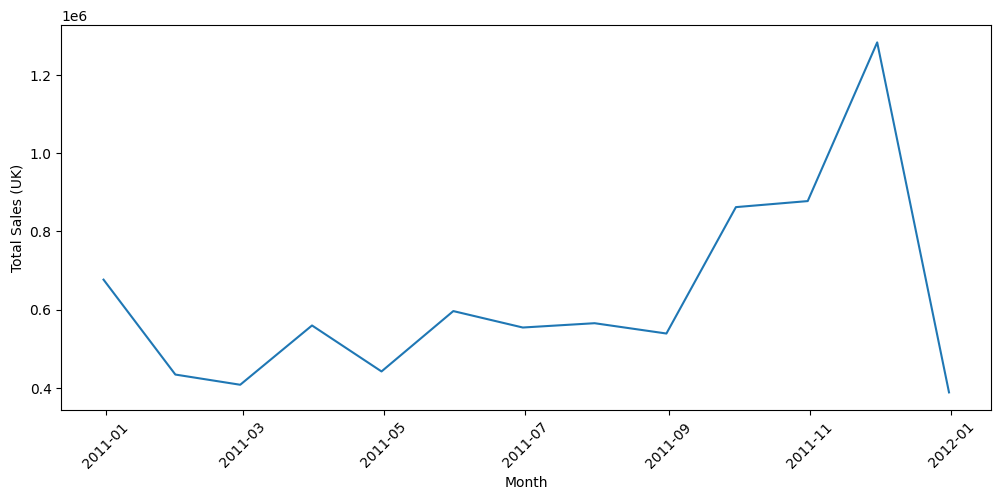

In [36]:
# UKonly series (busines[s focus)
uk_ts = df[df['Country']=='United Kingdom'].set_index('InvoiceDate').resample('M')['TotalPrice'].sum().reset_index()
plt.figure(figsize=(12,5))
plt.plot(uk_ts['InvoiceDate'], uk_ts['TotalPrice'])
plt.xlabel("Month")
plt.ylabel("Total Sales (UK)")
plt.xticks(rotation=45)
plt.show()


Top CLV customers (top 10):
 CustomerID       CLV  cum_spend  cum_perc  customer_rank  cum_customers_perc
    14646.0 279489.02  279489.02  3.367311              1            0.022873
    18102.0 256438.49  535927.51  6.456907              2            0.045746
    17450.0 187482.17  723409.68  8.715710              3            0.068618
    14911.0 132572.62  855982.30 10.312958              4            0.091491
    12415.0 123725.45  979707.75 11.803614              5            0.114364
    14156.0 113384.14 1093091.89 13.169677              6            0.137237
    17511.0  88125.38 1181217.27 14.231421              7            0.160110
    16684.0  65892.08 1247109.35 15.025295              8            0.182983
    13694.0  62653.10 1309762.45 15.780145              9            0.205855
    15311.0  59419.34 1369181.79 16.496035             10            0.228728


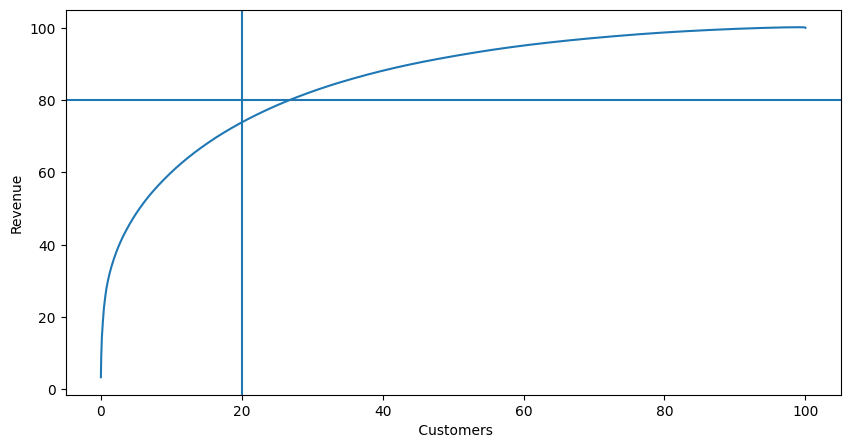

In [37]:
# 4) CLV distribution & Pareto (80/20)
clv = df.groupby('CustomerID')['TotalPrice'].sum().reset_index().rename(columns={'TotalPrice':'CLV'})
clv_sorted = clv.sort_values('CLV', ascending=False).reset_index(drop=True)
clv_sorted['cum_spend'] = clv_sorted['CLV'].cumsum()
total_spend = clv_sorted['CLV'].sum()
clv_sorted['cum_perc'] = 100 * clv_sorted['cum_spend'] / total_spend
clv_sorted['customer_rank'] = np.arange(1, len(clv_sorted)+1)
clv_sorted['cum_customers_perc'] = 100 * clv_sorted['customer_rank'] / len(clv_sorted)

if have_display_helper:
    display_dataframe_to_user("Top CLV customers (sample)", clv_sorted.head(20))
else:
    print("\nTop CLV customers (top 10):")
    print(clv_sorted.head(10).to_string(index=False))

plt.figure(figsize=(10,5))
plt.plot(clv_sorted['cum_customers_perc'], clv_sorted['cum_perc'])
plt.xlabel(" Customers")
plt.ylabel("Revenue")
plt.axhline(80)  
plt.axvline(20)  
plt.show()

In [38]:
# Find % customers that make 80% revenue
perc_80_idx = clv_sorted[clv_sorted['cum_perc'] >= 80].iloc[0]['customer_rank']
perc_80_customers = 100 * perc_80_idx / len(clv_sorted)
print(f"{perc_80_customers}%  customers acc for 80% of renenue")


26.784080512351327%  customers acc for 80% of renenue


In [39]:
# 5) RFM dis and corr
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()
rfm.columns = ['CustomerID','Recency','Frequency','Monetary']

if have_display_helper:
    display_dataframe_to_user("RFM sample", rfm.head(20))
else:
    print(rfm.head().to_string(index=False))

 CustomerID  Recency  Frequency  Monetary
    12346.0      326          2      0.00
    12347.0        2          7   4310.00
    12348.0       75          4   1797.24
    12349.0       19          1   1757.55
    12350.0      310          1    334.40


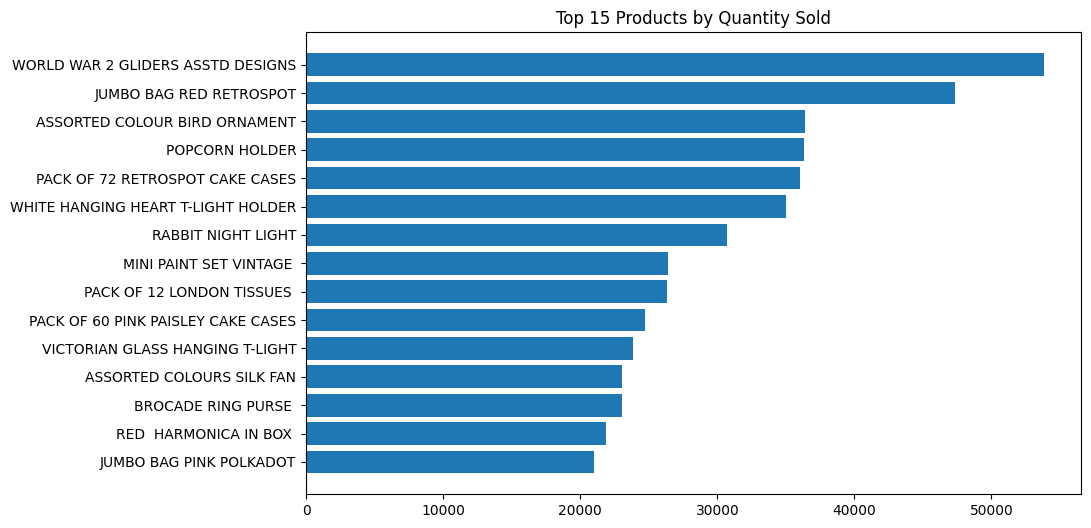

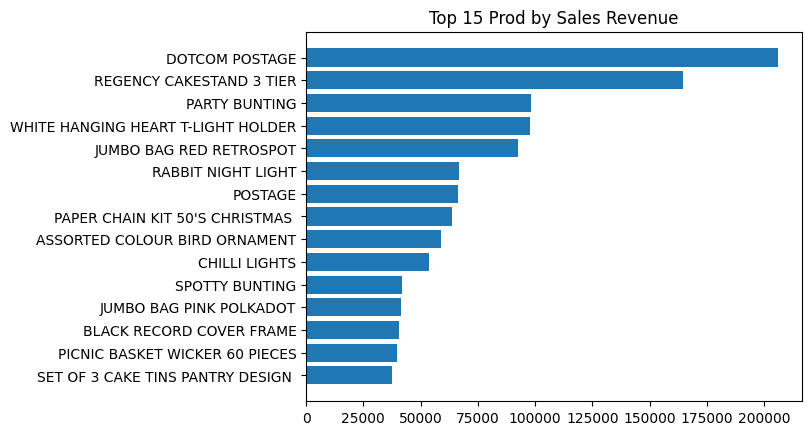

In [40]:
prod_qty = df.groupby(['StockCode','Description'])['Quantity'].sum().reset_index().sort_values('Quantity', ascending=False)
prod_sales = df.groupby(['StockCode','Description'])['TotalPrice'].sum().reset_index().sort_values('TotalPrice', ascending=False)

top_qty = prod_qty.head(20)
top_sales = prod_sales.head(20)

plt.figure(figsize=(10,6))
plt.barh(top_qty['Description'].head(15)[::-1], top_qty['Quantity'].head(15)[::-1])
plt.title("Top 15 Products by Quantity Sold")
plt.show()
plt.barh(top_sales['Description'].head(15)[::-1], top_sales['TotalPrice'].head(15)[::-1])
plt.title("Top 15 Prod by Sales Revenue")
plt.show()



In [41]:
if have_display_helper:
    display_dataframe_to_user("top prodct by  sold", top_qty)
    display_dataframe_to_user("Top products by sales", top_sales)
else:
    print("\ntop produc by quantity (top 10):")
    print(top_qty.head(10).to_string(index=False))
    print("\nTop product by sales (top 10")
    print(top_sales.head(10).to_string(index=False))


top produc by quantity (top 10):
StockCode                        Description  Quantity
    84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS     53847
   85099B            JUMBO BAG RED RETROSPOT     47363
    84879      ASSORTED COLOUR BIRD ORNAMENT     36381
    22197                     POPCORN HOLDER     36334
    21212    PACK OF 72 RETROSPOT CAKE CASES     36039
   85123A WHITE HANGING HEART T-LIGHT HOLDER     35025
    23084                 RABBIT NIGHT LIGHT     30680
    22492            MINI PAINT SET VINTAGE      26437
    22616         PACK OF 12 LONDON TISSUES      26315
    21977 PACK OF 60 PINK PAISLEY CAKE CASES     24753

Top product by sales (top 10
StockCode                        Description  TotalPrice
      DOT                     DOTCOM POSTAGE   206245.48
    22423           REGENCY CAKESTAND 3 TIER   164762.19
    47566                      PARTY BUNTING    98302.98
   85123A WHITE HANGING HEART T-LIGHT HOLDER    97715.99
   85099B            JUMBO BAG RED RETROSPOT  

In [42]:
df_clean = df_clean.sort_values(['CustomerID', 'InvoiceDate'])

df_clean['TimeDiff'] = df_clean.groupby('CustomerID')['InvoiceDate'].diff()

df_clean['NewSession'] = (df_clean['TimeDiff'] > pd.Timedelta(minutes=30)).astype(int)

df_clean['SessionID'] = df_clean.groupby('CustomerID')['NewSession'].cumsum()


In [43]:
session_features = df_clean.groupby('CustomerID')['SessionID'].nunique().reset_index()
session_features.columns = ['CustomerID', 'SessionCount']

df_clean = df_clean.merge(session_features, on='CustomerID', how='left')


In [44]:
# Average order value per session
session_stats = df_clean.groupby(['CustomerID','SessionID']).agg({
    'TotalPrice':'sum',
    'Quantity':'sum',
    'InvoiceDate':'max'
}).reset_index()

session_agg = session_stats.groupby('CustomerID').agg({
    'TotalPrice':'mean',
    'Quantity':'mean'
}).reset_index()

session_agg.columns = ['CustomerID', 'AvgSessionValue', 'AvgSessionQuantity']

df_clean = df_clean.merge(session_agg, on='CustomerID', how='left')

# Days active (number of unique shopping days)
active_days = df_clean.groupby('CustomerID')['InvoiceDate'].nunique().reset_index()
active_days.columns = ['CustomerID', 'ActiveDays']

df_clean = df_clean.merge(active_days, on='CustomerID', how='left')

# Week recency
df_clean['Week'] = df_clean['InvoiceDate'].dt.isocalendar().week
max_week = df_clean['Week'].max()

week_recency = df_clean.groupby('CustomerID')['Week'].max().reset_index()
week_recency['WeekRecency'] = max_week - week_recency['Week']
week_recency = week_recency[['CustomerID', 'WeekRecency']]

df_clean = df_clean.merge(week_recency, on='CustomerID', how='left')


In [45]:
customer_data = df_clean.groupby('CustomerID').agg({
    'Recency':'max',
    'Frequency':'max',
    'Monetary':'max',
    'SessionCount':'max',
    'AvgSessionValue':'max',
    'AvgSessionQuantity':'max',
    'ActiveDays':'max',
    'WeekRecency':'max',
    'CLV':'max',               # target
    'CountryCode':'max',
    'SeasonCode':'max'
}).reset_index()


In [46]:
from sklearn.model_selection import train_test_split

X = customer_data.drop(['CLV','CustomerID'], axis=1)
y = customer_data['CLV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=300,learning_rate=0.05,max_depth=5,random_state=42)
model.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,300
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,5
,min_impurity_decrease,0.0
,init,None


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("MAE:", mae)
print("R2 Score:", r2)


RMSE: 0.05479508928919778
MAE: 0.003541207712935676
R2 Score: 0.9117374770952898


Random Forest Regressor

RMSE: 0.048642409276525814
Random Forest R²: 0.9304458232834858


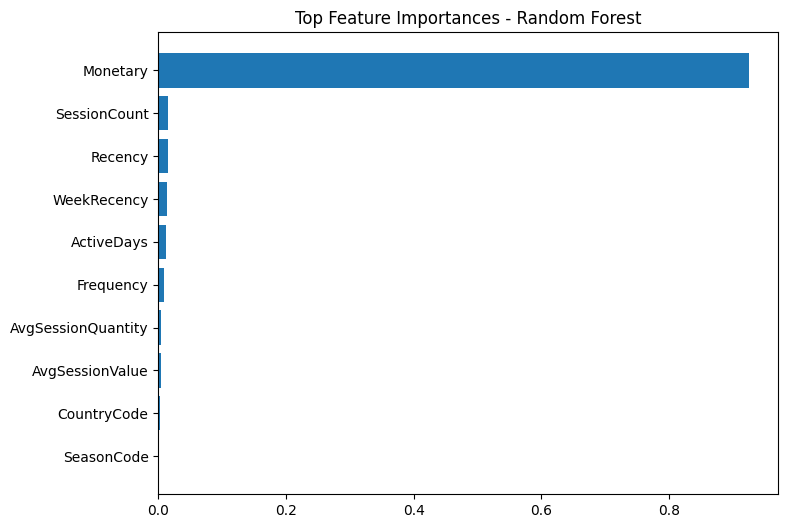

In [49]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score

rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
rf_r2 = r2_score(y_test, rf_preds)

print("RMSE:", rf_rmse)
print("Random Forest R²:", rf_r2)

# Feature importance
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(8,6))
plt.barh(importances['feature'][:20][::-1], importances['importance'][:20][::-1])
plt.title("Top Feature Importances - Random Forest")
plt.show()


elasticNet=linear Regression+ regularization

In [50]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

params = {
    "alpha": [0.01, 0.1, 1, 10],
    "l1_ratio": [0.1, 0.5, 0.9]
}

enet = ElasticNet(max_iter=5000, random_state=42)

grid = GridSearchCV(enet, params, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(X_train, y_train)

best_enet = grid.best_estimator_
enet_preds = best_enet.predict(X_test)

enet_rmse = np.sqrt(mean_squared_error(y_test, enet_preds))
enet_r2 = r2_score(y_test, enet_preds)

print("ElasticNet RMSE:", enet_rmse)
print("ElasticNet R²:", enet_r2)
print("Best Params:", grid.best_params_)


ElasticNet RMSE: 0.03614233546088401
ElasticNet R²: 0.9616005075194968
Best Params: {'alpha': 0.01, 'l1_ratio': 0.1}


In [ ]:
import numpy as np

threshold = customer_data['CLV'].quantile(0.75)
customer_data['HighValue'] = (customer_data['CLV'] >= threshold).astype(int)

X = customer_data.drop(['CLV','CustomerID','HighValue'], axis=1)
y = customer_data['HighValue']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)


Stratified 5-Fold Cross-Validation + AUC-ROC

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

auc_scores = cross_val_score(
    model, X, y,
    scoring='roc_auc',
    cv=skf,
    n_jobs=-1
)

print("AUC scores:", auc_scores)
print("Mean AUC:", auc_scores.mean())


AUC scores: [1.         1.         0.99987966 1.         1.        ]
Mean AUC: 0.9999759321002074


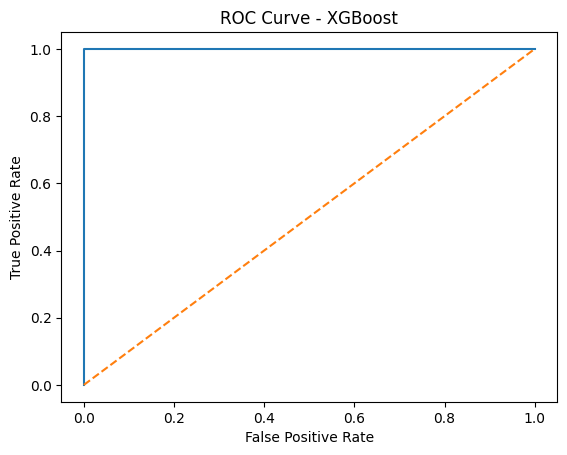

In [55]:
model.fit(X_train, y_train)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.show()

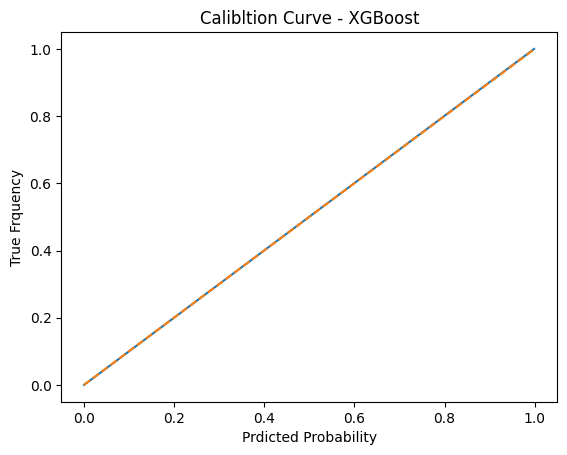

Brier Score: 8.282356289176146e-07


In [57]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)

plt.plot(prob_pred, prob_true)
plt.plot([0,1], [0,1], linestyle="--")
plt.title("Calibltion Curve - XGBoost")
plt.xlabel("Prdicted Probability")
plt.ylabel("True Frquency")
plt.show()

brier = brier_score_loss(y_test, y_proba)
print("Brier Score:", brier)